# Swaption Pricing Part 2: American Monte Carlo for Bermudas

*Copyright (c) 2015 Matthias Groncki*


Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

    - Redistributions of source code must retain the above copyright notice,
    this list of conditions and the following disclaimer.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDERS OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

This disclaimer is taken from the QuantLib license

In [1]:
# import the used libraries
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import QuantLib as ql
%matplotlib inline

In [2]:
# Setting evaluation date
today = ql.Date(7,4,2015)
ql.Settings.instance().setEvaluationDate(today)

In [3]:
# Setup Marketdata
rate = ql.SimpleQuote(0.03)
rate_handle = ql.QuoteHandle(rate)
dc = ql.Actual365Fixed()
yts = ql.FlatForward(today, rate_handle, dc)
yts.enableExtrapolation()
hyts = ql.RelinkableYieldTermStructureHandle(yts)
t0_curve = ql.YieldTermStructureHandle(yts)
euribor6m = ql.Euribor6M(hyts)
cal = ql.TARGET()

In [4]:
# Setup a dummy portfolio with two Swaps
def makeSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
    """
    creates a plain vanilla swap with fixedLegTenor 1Y
    
    parameter:
        
        start (ql.Date) : Start Date
        
        maturity (ql.Period) : SwapTenor
        
        nominal (float) : Nominal
        
        fixedRate (float) : rate paid on fixed leg
        
        index (ql.IborIndex) : Index
        
    return: tuple(ql.Swap, list<Dates>) Swap and all fixing dates
    
        
    """
    end = ql.TARGET().advance(start, maturity)
    fixedLegTenor = ql.Period("1y")
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start,
                                end, 
                                fixedLegTenor, 
                                index.fixingCalendar(), 
                                fixedLegBDC,
                                fixedLegBDC, 
                                ql.DateGeneration.Backward,
                                False)
    floatSchedule = ql.Schedule(start,
                                end,
                                index.tenor(),
                                index.fixingCalendar(),
                                index.businessDayConvention(),
                                index.businessDayConvention(),
                                ql.DateGeneration.Backward,
                                False)
    swap = ql.VanillaSwap(typ, 
                          nominal,
                          fixedSchedule,
                          fixedRate,
                          fixedLegDC,
                          floatSchedule,
                          index,
                          spread,
                          index.dayCounter())
    return swap, [index.fixingDate(x) for x in floatSchedule][:-1]


def makeSwaption(swap, callDates, settlement):
    if len(callDates) == 1:
        exercise = ql.EuropeanExercise(callDates[0])
    else:
        exercise = ql.BermudanExercise(callDates)
    return ql.Swaption(swap, exercise, settlement)




## Lets start with an european swaption

Create a forward starting plain vanilla swap using the helper function above and create a european swaption which allows us to to enter the swap in one year from today.

In [5]:
settlementDate = today + ql.Period("1Y")

swaps = [makeSwap(settlementDate,
                  ql.Period("5Y"),
                  1e6,
                  0.03047096,
                  euribor6m)
        ]

calldates = [euribor6m.fixingDate(settlementDate), euribor6m.valueDate(ql.Date(5,4,2017))]
 
swaptions = [makeSwaption(swap, 
                          calldates, 
                          ql.Settlement.Physical) 
             for swap, fd in swaps]

Pricing of the underlying at time 0 using the QuantLib pricing engine

In [6]:
#%%timeit
# Setup pricing engine and calculate the npv of the underlying swap
engine = ql.DiscountingSwapEngine(hyts)
for swap, fixingDates in swaps:
    swap.setPricingEngine(engine)
    print("Swap NPV at time 0: %.4f" % swap.NPV())


Swap NPV at time 0: 0.0091


###Setup the Gaussian Shortrate model (a.k.a Hull White model)

Don't worry about calibration, assume we know the calbriated model parameter

In [7]:
# Stochastic Process 

In [8]:
# Assume the model is already calibrated either historical or market implied
volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)),
         ql.QuoteHandle(ql.SimpleQuote(0.0075))]
meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.002))]
model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 16.)
process = model.stateProcess()

###Calculate the swaption price using an integral pricing engine

In [9]:
swaptionEngine = ql.Gaussian1dSwaptionEngine(model)

In [10]:
for swaption in swaptions:
    swaption.setPricingEngine(swaptionEngine)
    print("Swaption NPV : %.2f" % swaption.NPV())

Swaption NPV : 17068.93


###Pricing with an Monte Carlo method

####Create a swap path pricer in Python 

Convert all Dates into times in years (using the same DayCounter as in the yieldTermStructure and store all fix cashflows in a numpy array.

In [11]:
mcDC = yts.dayCounter()

def timeFromReferenceFactory(daycounter, ref):
    """
    returns a function, that calculate the time in years
    from a the reference date *ref* to date *dat* 
    with respect to the given DayCountConvention *daycounter*
    
    Parameter:
        dayCounter (ql.DayCounter)
        ref (ql.Date)
        
    Return:
    
        f(np.array(ql.Date)) -> np.array(float)
    """
    def impl(dat):
        return daycounter.yearFraction(ref, dat)
    return np.vectorize(impl)

timeFromReference = timeFromReferenceFactory(mcDC, today)

In [12]:
def getFixedLeg(swap, t):
    """
    returns all future payment times and amount of the fixed leg of the underlying swap
    
    Parameter:
        swap (ql.Swap)
        t (float) 
        
    Return:
        (np.array, np.array) (times, amounts)

    """
    fixed_leg = swap.leg(0)
    n = len(fixed_leg)
    fixed_times=[]
    fixed_amounts=[]
    npv = 0
    for i in range(n):
        cf = fixed_leg[i]
        t_i = timeFromReference(cf.date())
        if t_i > t:
            fixed_times.append(t_i)
            fixed_amounts.append(cf.amount())
    return np.array(fixed_times), np.array(fixed_amounts)


def getFloatingLeg(swap, t):
    
    float_leg = swap.leg(1)
    n = len(float_leg)
    float_times = []
    float_dcf = []
    accrual_start_time = []
    accrual_end_time = []
    nominals = []
    for i in range(n):
        # convert base classiborstart_idx Cashflow to
        # FloatingRateCoupon
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i >= t:
            iborIndex = cf.index()
            
            index_mat = cf.referencePeriodEnd()
            # year fraction
            float_dcf.append(cf.accrualPeriod())
            # calculate the start and end time
            accrual_start_time.append(t_fix_i)
            accrual_end_time.append(timeFromReference(index_mat))
            # payment time
            float_times.append(t_i)
            # nominals 
            nominals.append(cf.nominal())
    return np.array(float_times), np.array(float_dcf), np.array(accrual_start_time), np.array(accrual_end_time), np.array(nominals)


def swapPathNPV(swap, t):
    fixed_times, fixed_amounts = getFixedLeg(swap, t)
    float_times, float_dcf, accrual_start_time, accrual_end_time, nominals = getFloatingLeg(swap, t)
    df_times = np.concatenate([fixed_times, 
                           accrual_start_time, 
                           accrual_end_time, 
                           float_times])
    df_times = np.unique(df_times)
    # Store indices of fix leg payment times in 
    # the df_times array
    fix_idx = np.in1d(df_times, fixed_times, True)
    fix_idx = fix_idx.nonzero()
    # Indices of the floating leg payment times 
    # in the df_times array
    float_idx = np.in1d(df_times, float_times, True)
    float_idx = float_idx.nonzero()
    # Indices of the accrual start and end time
    # in the df_times array
    accrual_start_idx = np.in1d(df_times, accrual_start_time, True)
    accrual_start_idx = accrual_start_idx.nonzero()
    accrual_end_idx = np.in1d(df_times, accrual_end_time, True)
    accrual_end_idx = accrual_end_idx.nonzero()
    # Calculate NPV
    def calc(x_t):
        discount = np.vectorize(lambda T: model.zerobond(T, t, x_t))
        dfs = discount(df_times)
        # Calculate fixed leg npv
        fix_leg_npv = np.sum(fixed_amounts * dfs[fix_idx])
        # Estimate the index fixings
        index_fixings = (dfs[accrual_start_idx] / dfs[accrual_end_idx] - 1) 
        index_fixings /= float_dcf
        # Calculate the floating leg npv
        float_leg_npv = np.sum(nominals * index_fixings * float_dcf * dfs[float_idx])
        npv = float_leg_npv - fix_leg_npv
        return npv
    return calc

In [13]:
# Convert call date to time
callTimes = timeFromReference(calldates)
callTimes

array([ 0.99726027,  2.00273973])

####Test the t0 Swap Pricing

In [14]:
npv = swapPathNPV(swap, 0.)(0)
print("Swap NPV at time 0: %.4f" % npv)
print("Error : %.8f" % (npv - swap.NPV()))

Swap NPV at time 0: 0.0091
Error : 0.00000000


###Monte Carlo Simulation

#### Generate time grid and paths

In [15]:
def fixingdates(swap):
    leg = swap.leg(1)
    n = len(leg)
    fixing_dates = []
    for i in range(0, n):
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        fixing_dates.append(value_date)
    return fixing_dates

# Define evaluation grid

date_grid = [today] + calldates 

date_grid = np.unique(np.sort(date_grid))
time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
dt = time_grid[1:] - time_grid[:-1]


In [16]:
date_grid

array([Date(7,4,2015), Date(5,4,2016), Date(7,4,2017)], dtype=object)

In [28]:
time_grid

array([ 0.        ,  0.99726027,  2.00273973])

In [17]:
# Random number generator
seed = 1
urng = ql.MersenneTwisterUniformRng(seed)
usrg = ql.MersenneTwisterUniformRsg(len(time_grid)-1,urng)
generator = ql.InvCumulativeMersenneTwisterGaussianRsg(usrg)

In [18]:
#%%timeit
# Generate N paths
M = 100000
m = len(time_grid)
x = np.zeros((M, m))
y = np.zeros((M, m))
numeraires = np.zeros((M, m))
                      
for n in range(0, M):
    numeraires[n, 0] = model.numeraire(0, 0)
    
for n in range(0,M):
    dWs = generator.nextSequence().value()
    j = 1
    for i in range(1, len(time_grid)):
        t0 = time_grid[i-1]
        t1 = time_grid[i]
        e = process.expectation(t0, 
                                x[n,i-1], 
                                dt[i-1])
        std = process.stdDeviation(t0,
                                   x[n,i-1],
                                   dt[i-1])
        x[n,i] = e + dWs[i-1] * std 
        e_0_0 = process.expectation(0,0,t1)
        std_0_0 = process.stdDeviation(0,0,t1)
        y[n,i] = (x[n,i] - e_0_0) / std_0_0
        numeraires[n, i] = model.numeraire(t1, y[n,i])
        #df_times_temp = df_times.copy()
        #df_times_temp[df_times_temp <= t1] = t1
        #dfs[n,i] = np.vectorize(lambda T: model.zerobond(T, t1, y[n,i]))(df_times_temp)

In [19]:

                         
pricer = np.vectorize(swapPathNPV(swap, time_grid[-1]))

cont_value = pricer(y[:,-1]) / numeraires[:,-1]
cont_value[cont_value < 0] = 0



In [20]:
time_grid

array([ 0.        ,  0.99726027,  2.00273973])

In [21]:
pricer = np.vectorize(swapPathNPV(swap, time_grid[-2]))
exercise_values = pricer(y[:,-2]) / numeraires[:,-2]
exercise_values[exercise_values < 0] = 0

In [50]:
states = y[:, -2]
Y = np.column_stack((states, states**2, states**3, states**4))
Y = sm.add_constant(Y)
ols = sm.OLS(cont_value, Y)
ols_result = ols.fit()
cont_value_hat = np.sum(ols_result.params * Y, axis=1)
npv_amc = np.maximum(cont_value_hat, exercise_values)

In [51]:
ols_result.params

array([ 15476.68970108,  22203.99784323,   9906.4788144 ,    589.72935045,
         -282.14303658])

In [46]:
npv_amc = np.mean(npv_amc) * numeraires[0,0]

In [47]:
npv_amc

17011.521601274337

In [48]:
print("MC NPV: %.4f" % npv_amc)
print("Error : %.4f " % (npv_amc-swaption.NPV()))
print("Rel. Error in bps: %.4f " % ((npv_amc-swaption.NPV()) / 100))

MC NPV: 17011.5216
Error : -57.4077 
Rel. Error in bps: -0.5741 


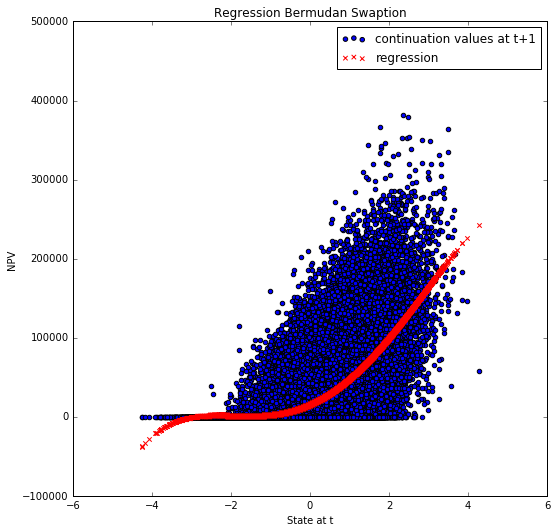

In [53]:
plt.figure(figsize=(8.5,8.5))
plt.scatter(states, cont_value)
plt.scatter(states, cont_value_hat, marker='x', c='red')
plt.legend(["continuation values at t+1", "regression"])
plt.title("Regression Bermudan Swaption")
plt.xlabel("State at t")
plt.ylabel("NPV")

In [27]:
numeraires[:,1]

array([ 0.65652302,  0.60137971,  0.96419477, ...,  0.58020483,
        0.62947565,  0.62142583])